# Optimising Background Fits
Given we know now using a least-squares fitting method that the quadratic will be the best model, we can use a more sophisticated fit in this case a minimisation of the negative log likelihood or a "maximum likelihood" estimation.

In [21]:
# Necessary imports, remember to clean this up
import numpy as np
import pandas as pd
import sys
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
sys.path.append('../')
from utilities import Data, Consts, Model
import data_pipeline as dp

In [22]:
r = Data(*Consts().get_real_tuple())
bg = r.fetch_features(['Lb_M'])
# Get the masses from each of the events

## Plotting Mass Distribution
It is always nice to plot these data before we begin any further analysis. In this case plotting the reconstructed $\Lambda_B^0$ mass distribution. 

In [23]:
low_mass_limit, high_mass_limit = 4500, 6500
# Set some upper and lower bands on the region we consider
no_bins = 100
# This is arbitrary

bins = np.linspace(low_mass_limit, high_mass_limit, no_bins + 1)
bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]
# Calculate a bin distribution first

bg = bg[bg['Lb_M'].between(low_mass_limit, high_mass_limit)]
# Apply the mass range restriction

f, _ = np.histogram(bg['Lb_M'], bins=bins)
# Generate a histogram using said bin structre
err = np.sqrt(f)
# Assume Poisson statistics so that the errors are proportional to the count

d = np.array([bin_centres, f, err]).T
# Combine all the useful data into a large array

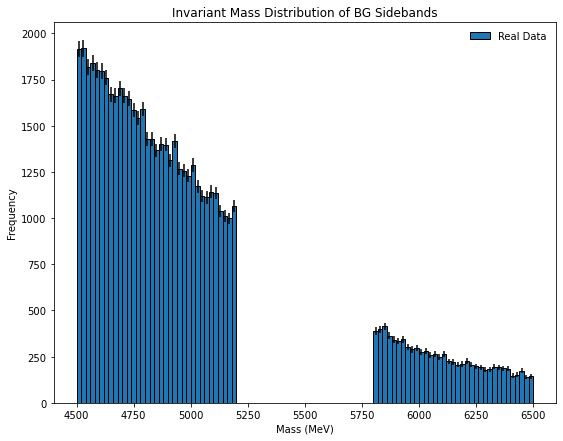

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Real Data', edgecolor='k')
ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of BG Sidebands')
plt.show()

## Least-Squares Fit
Below we quickly do a least-squares fit and plot the optimised fit. We do not bother calculating a chi-square metric yet since the purpose of this notebook is not to showcase a least-squares fit.

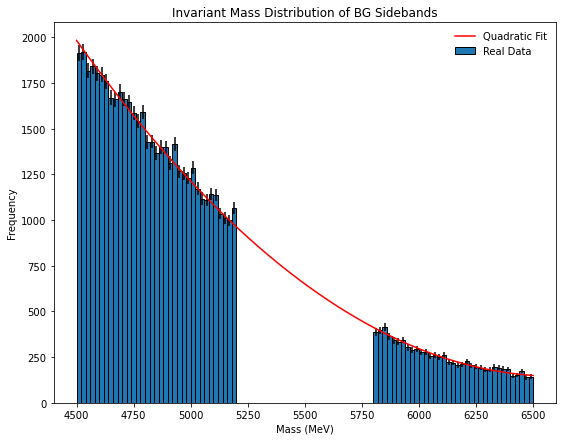

In [25]:
d = d[(d[:,1] != 0)]
# Remove all the rows with zero count in the blinded region

x, y, yerr = d[:,0], d[:,1], d[:,2]
# Curve fit can take errors which then performs a standard chi-square minimisation

popt, pcov = curve_fit(Model.quadratic, x, y, [1e-3, -5, 2e4], yerr, absolute_sigma=True)
# Do the optimisation

func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
# Make a "x-axis" for the optimised function to be plotted on, 500 points for smoothness

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Real Data', edgecolor='k')
ax.plot(func_x, Model.quadratic(func_x, *popt), label='Quadratic Fit', color='red')
ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of BG Sidebands')
plt.show()

In [26]:
popt, np.sqrt(np.diag(pcov))

(array([ 4.15827009e-04, -5.49103313e+00,  1.82726280e+04]),
 array([9.69344624e-06, 1.08972880e-01, 3.03033435e+02]))

## Maximum-Likelihood Fit
Now we will use the more scientifically accepted technique of a maximum likelihood fit.

In [27]:
import numpy as np
import numdifftools as ndt
import pandas as pd
import pymc3 as pm

In [79]:


df = pd.DataFrame({'y': d[:,1], 'x': d[:,0]})
# Put the data into a nice datafrrame
df['constant'] = d[:,2]
# Needed so that PYCM3 doesn't die
df.head()

,y,x,constant
0,1917.0,4510.0,43.783559
1,1918.0,4530.0,43.794977
2,1818.0,4550.0,42.638011
3,1841.0,4570.0,42.906876
4,1803.0,4590.0,42.461747


In [80]:
# Our model is ax^2 + bx + c

with pm.Model() as model:
    b2 = pm.Flat('x^2', testval=4.15827009e-04)
    b1 = pm.Flat('x^1', testval=-5.49103313e+00)
    b0 = pm.Flat('x^0', testval=1.82726280e+04)
    sigma = pm.Flat('sigma', testval=1e2)
    # Some of our parameters
    
    mu = b2*((df.x)**2) + (b1*df.x) + b0
    # Define the function
    
    like = pm.Normal('like', mu=mu, sd=sigma, observed=df.y)
    # Define the likelihood

In [81]:
with model:
    # Find the MLE and Hessian matrix
    beta_mle = pm.find_MAP()
    hessian = pm.find_hessian(beta_mle)

In [82]:
se_1 = np.sqrt(np.diag(np.linalg.inv(hessian)))    
se = se_1[::-1]
# Find the standard errors

f = np.array([beta_mle['x^2'], beta_mle['x^1'], beta_mle['x^0']])
results = pd.DataFrame({'parameters': f,'std err': se[:-1]})
results.index=['Quadratic','Linear','Constant']   
results.head()

,parameters,std err
Quadratic,0.000416,NaN
Linear,-5.491033,NaN
Constant,18272.628000,NaN


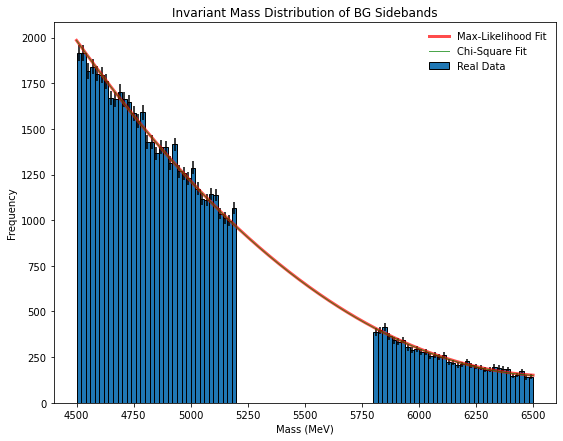

In [84]:
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
# Make a "x-axis" for the optimised function to be plotted on, 500 points for smoothness

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Real Data', edgecolor='k')
ax.plot(func_x, Model.quadratic(func_x, *results['parameters'].to_list()), label='Max-Likelihood Fit', color='red', alpha=0.7, linewidth=3)
ax.plot(func_x, Model.quadratic(func_x, *popt), label='Chi-Square Fit', color='green', alpha=0.7, linewidth=1)
ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of BG Sidebands')
plt.savefig('../../images/BackgroundFits/Quadratic_Chi_And_MLE.png', dpi=800)